## Plotting eke timeseries for Fig. S3 of Ong et al. 2025 "Transient Antarctic Slope Current Response to Climate Change including Meltwater"
EKE is calculated relative to a rolling mean with rolling window of 120 days
start with input files from dataMW_accessEKE_rolling.ipynb

To plot only the final figure the energy data files required are:
* energy_rolling_MEAN_W120_01deg_jra55v13_ryf9091_qian_wthmp_shelf_600m_sans_canyons.nc
* energy_rolling_MEAN_W120_01deg_jra55v13_ryf9091_qian_wthmp_slope_600m_sans_canyons.nc
* energy_surf_total_W120_01deg_jra55v13_ryf9091_qian_wthmpshelf_600m_sans_canyons.nc
* energy_surf_total_W120_01deg_jra55v13_ryf9091_qian_wthmpslope_600m_sans_canyons.nc
* speed2_rolling_uup_vvp_W120_01deg_jra55v13_ryf9091_qian_wthmpshelf_600m_sans_canyons.nc
* speed2_rolling_uup_vvp_W120_01deg_jra55v13_ryf9091_qian_wthmpslope_600m_sans_canyons.nc

In [1]:
import os

import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

import matplotlib.dates as mdates
import datetime
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [4]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_wthmp


In [5]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'


In [72]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28

memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=1)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/32831/status,
Dashboard: /proxy/32831/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.15:46005,Workers: 0
Dashboard: /proxy/32831/status,Total threads: 0
Started: Just now,Total memory: 0 B


## load variables - generated in dataMW_accessEKE_rolling.ipynb

In [7]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))

In [8]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s

In [9]:

cluster_mask_shelfwcanyons = ~xr.open_mfdataset('/home/561/qo9901/MW-perturb-ASC/nc_files/600misobath_sans_canyons_cluster_mask_xr_accessom201.nc')
## note inverse in cluster_mask_shelfwcanyons
cluster_mask_shelfwcanyons= cluster_mask_shelfwcanyons.assign_coords(xu_ocean = ('xu_ocean', hu.xu_ocean.data), yu_ocean = ('yu_ocean', hu.yu_ocean.data))
# cluster_mask_shelfwcanyons == True: Shelf 
mask_shelf = xr.where(cluster_mask_shelfwcanyons == True , True, False)
mask_slope = xr.where(cluster_mask_shelfwcanyons == False, True, False)
#mask_slope = hu.where(cluster_mask_shelfwcanyons == False, True, False)

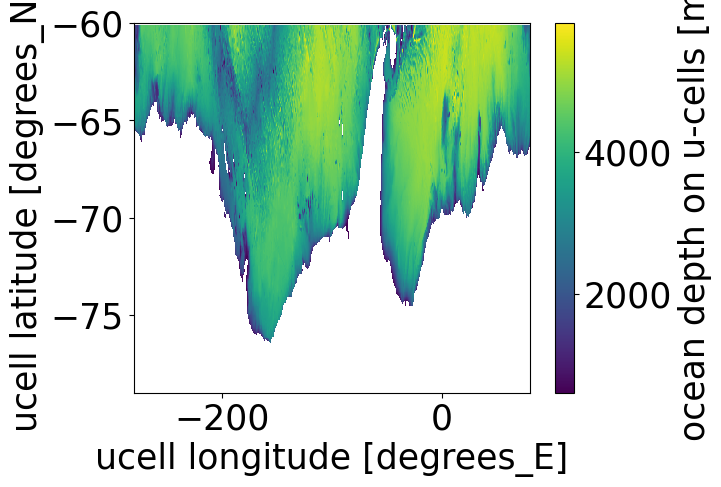

In [10]:
hu.where(mask_slope== True).__xarray_dataarray_variable__.plot()

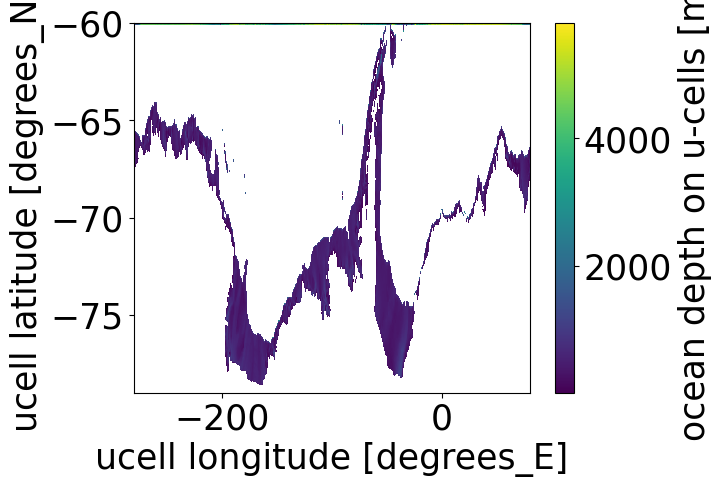

In [11]:
hu.where(mask_shelf== True).__xarray_dataarray_variable__.plot()

mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [14]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [15]:
## plotting everything together
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
#calculating area on shelf and slope total
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)
circ_area_slope = (area_u*cluster_mask_access.where(mask_slope ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
circ_area_shelf = (area_u*cluster_mask_access.where(mask_shelf ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
circ_area_total = (area_u*cluster_mask_access).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           


In [16]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [17]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [18]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [19]:
vel = xr.merge([hu,coordinates, u, v, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [20]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [21]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [22]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(vel.hu, 'X') / grid.interp(vel.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(vel.hu, 'Y', boundary='extend') / grid.interp(vel.dyt, 'X'), 'Y', boundary='extend')# 'X')
dhu_dx

<xarray.DataArray (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<interp_center_to_right, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

In [23]:
# Calculate the magnitude of the topographic slope
slope = np.sqrt(dhu_dx**2 + dhu_dy**2).rename('slope')

In [24]:
import gc

In [25]:
windows= 120

In [26]:
cluster_mask_access= cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', u.xu_ocean.data), yu_ocean = ('yu_ocean', u.yu_ocean.data))

In [27]:
## open u and v with rolling window of 120 days

In [28]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
u_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/v_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
v_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__


In [29]:
chunksize = 37

In [31]:
def calc_u_along_integral_mask_tt(tt, chunk_size, mask_region, u_input, v_input):
    u_t = u_input.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    v_t = v_input.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    
    u_comp = (u_t*dhu_dy/slope).__xarray_dataarray_variable__#.compute()
    v_comp = (v_t*dhu_dx/slope).__xarray_dataarray_variable__#.compute()
    u_along = u_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50}) - v_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50})
    u_along_tt = grid.integrate(u_along, axis = {'X', 'Y'}).load()#.values
    print(tt)
    return u_along_tt

In [32]:

%%time
u_along_eddy_slopematrix =[]
u_along_eddy_shelfmatrix = []
for tt in range(13):
    u_transient_clim = u.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    u_along_eddy_slope = calc_u_along_integral_mask_tt(0, chunksize, mask_slope, u_transientsel, v_transientsel)  
    u_along_eddy_slopematrix.append(u_along_eddy_slope)
    u_along_eddy_shelf = calc_u_along_integral_mask_tt(0, chunksize, mask_shelf, u_transientsel, v_transientsel)  
    u_along_eddy_shelfmatrix.append(u_along_eddy_shelf)
    del u_along_eddy_slope, u_along_eddy_shelf
    print('tt = ' + str(tt))

loading
0
0
tt = 0
loading
0
0
tt = 1
loading
0
0
tt = 2
loading
0
0
tt = 3
loading
0
0
tt = 4
loading
0
0
tt = 5
loading
0
0
tt = 6
loading
0
0
tt = 7
loading
0
0
tt = 8
loading
0
0
tt = 9
loading
0
0
tt = 10
loading
0
0
tt = 11
loading
0
0
tt = 12
CPU times: user 4min 20s, sys: 2min 59s, total: 7min 20s
Wall time: 11min 6s


In [33]:
u_along_eddy_slopex = xr.merge([u_along_eddy_slopematrix[i].rename('ualong_eddy') for i in np.arange(int(len(u_along_eddy_slopematrix)))])/circ_area_slope        
u_along_eddy_shelfx = xr.merge([u_along_eddy_shelfmatrix[i].rename('ualong_eddy') for i in np.arange(int(len(u_along_eddy_shelfmatrix)))])/circ_area_shelf  

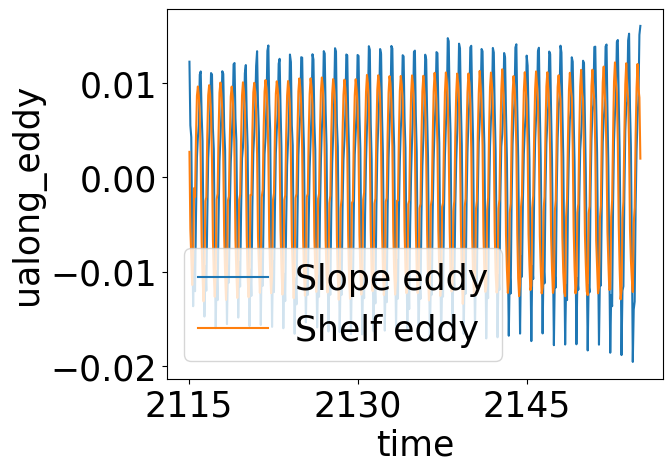

In [34]:
u_along_eddy_slopex.ualong_eddy.plot(label = 'Slope eddy')
u_along_eddy_shelfx.ualong_eddy.plot(label = 'Shelf eddy')
plt.legend()

In [35]:
u_along_eddy_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/u_along_rolling_EDDY_W' \
                              + str(windows) + '_' + expt+ 'shelf_600m_sans_canyons.nc')
u_along_eddy_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/u_along_rolling_EDDY_W' \
                              + str(windows) + '_' + expt+ 'slope_600m_sans_canyons.nc')

In [36]:
u_along_slopematrix =[]
u_along_shelfmatrix = []
for tt in range(13):

    u_along_slope = calc_u_along_integral_mask_tt(0, chunksize, mask_slope,\
                           u.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)),  v.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) )  
    u_along_slopematrix.append(u_along_slope)
    u_along_shelf = calc_u_along_integral_mask_tt(0, chunksize, mask_shelf, \
                           u.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)),  v.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) )  
    u_along_shelfmatrix.append(u_along_shelf)
    del u_along_slope, u_along_shelf
    print('tt = ' + str(tt))

0
0
tt = 0
0
0
tt = 1
0
0
tt = 2
0
0
tt = 3
0
0
tt = 4
0
0
tt = 5
0
0
tt = 6
0
0
tt = 7
0
0
tt = 8
0
0
tt = 9
0
0
tt = 10
0
0
tt = 11
0
0
tt = 12


In [37]:
u_along_slopex = xr.merge([u_along_slopematrix[i].rename('ualong') for i in np.arange(int(len(u_along_slopematrix)))])/circ_area_slope        
u_along_shelfx = xr.merge([u_along_shelfmatrix[i].rename('ualong') for i in np.arange(int(len(u_along_shelfmatrix)))])/circ_area_shelf                                 

In [39]:
u_along_slopex

<xarray.Dataset> Size: 8kB
Dimensions:  (time: 481)
Coordinates:
  * time     (time) object 4kB 2115-01-16 12:00:00 ... 2155-01-16 12:00:00
Data variables:
    ualong   (time) float64 4kB -0.02129 -0.02809 -0.02938 ... -0.05993 -0.05915

In [ ]:
# looking at ualong mean and eddy components for new slope and shelf definitions for a sanity check

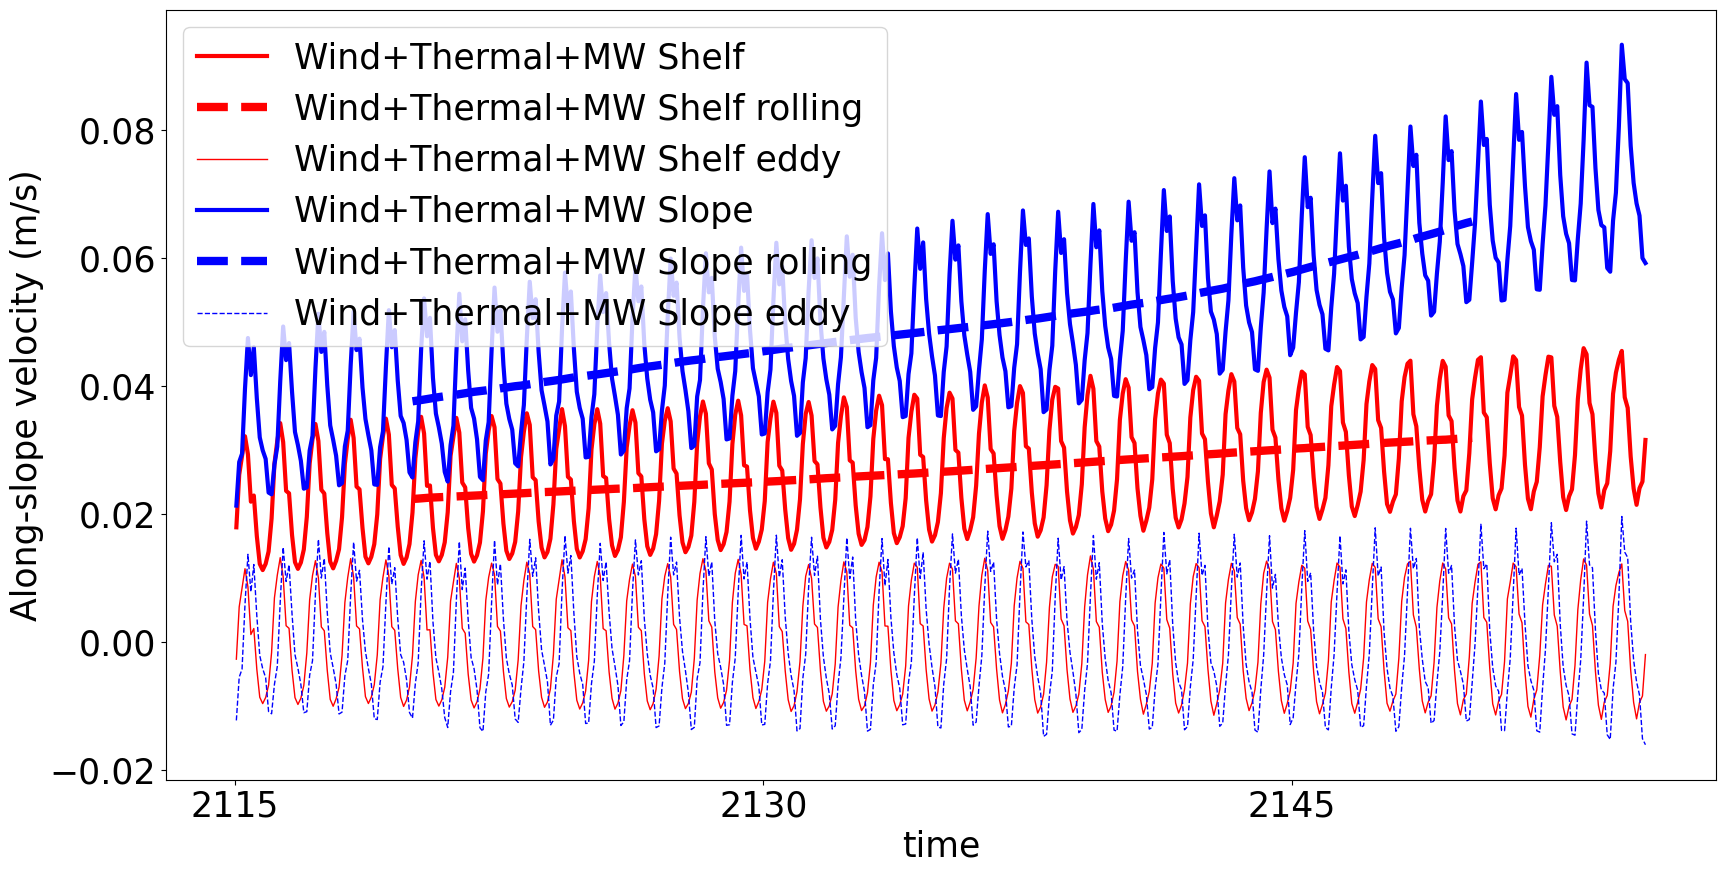

In [41]:
plt.figure(figsize = (20,10))
(-u_along_shelfx).ualong.plot( label = 'Wind+Thermal+MW Shelf', color = 'r',lw =3)
(-u_along_shelfx).rolling(time = windows, center = True).mean().ualong.plot( label = 'Wind+Thermal+MW Shelf rolling', linestyle = 'dashed',  color = 'r', lw = 6)
(- u_along_eddy_shelfx.ualong_eddy).plot( label = 'Wind+Thermal+MW Shelf eddy', color = 'r', lw =1)

(-u_along_slopex).ualong.plot( label = 'Wind+Thermal+MW Slope',color = 'b', lw =3)
(-u_along_slopex).rolling(time = windows, center = True).mean().ualong.plot( label = 'Wind+Thermal+MW Slope rolling', linestyle = 'dashed', color = 'b', lw =6)
(- u_along_eddy_slopex.ualong_eddy).plot( label = 'Wind+Thermal+MW Slope eddy', linestyle = 'dashed', color = 'b', lw =1)

plt.ylabel('Along-slope velocity (m/s)')
plt.legend(fontsize = 25)
#plt.ylim([0,0.17])

## skip if only plotting - decomposing mean speed into shelf and slope 
using rolling window of 120 days

In [42]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
u_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/v_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
v_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__


In [43]:
chunksize = 13

In [44]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
energy_mean_slopematrix =[]
energy_mean_shelfmatrix = []
for tt in range(37):
    u_transient_clim = u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    energy_mean_slope = (u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    energy_mean_slopematrix.append(grid.integrate(energy_mean_slope, axis = {'X','Y'}).load())
    
    energy_mean_shelf = (u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    energy_mean_shelfmatrix.append(grid.integrate(energy_mean_shelf, axis = {'X','Y'}).load())
    
    del energy_mean_slope, energy_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
loading
tt = 20
loading
tt = 21
loading
tt = 22
loading
tt = 23
loading
tt = 24
loading
tt = 25
loading
tt = 26
loading
tt = 27
loading
tt = 28
loading
tt = 29
loading
tt = 30
loading
tt = 31
loading
tt = 32
loading
tt = 33
loading
tt = 34
loading
tt = 35
loading
tt = 36
CPU times: user 1min 41s, sys: 1min 24s, total: 3min 5s
Wall time: 4min 52s


In [45]:
energy_mean_slopex = xr.merge([energy_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_mean_slopematrix)))])/circ_area_slope        
energy_mean_shelfx = xr.merge([energy_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_mean_shelfmatrix)))])/circ_area_shelf                                 

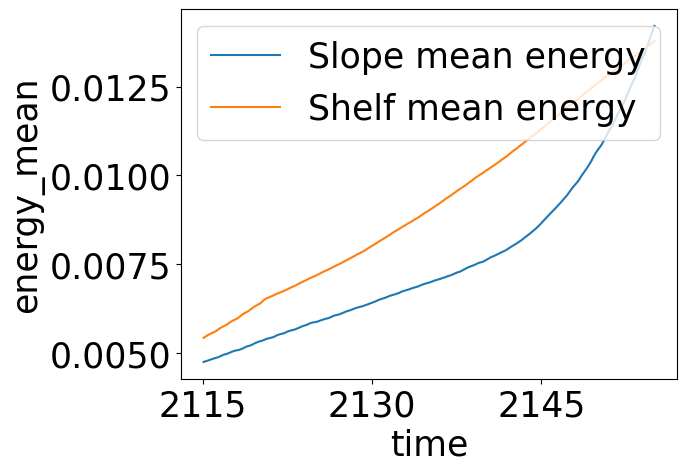

In [46]:
energy_mean_slopex.energy_mean.plot(label = 'Slope mean energy')
energy_mean_shelfx.energy_mean.plot(label = 'Shelf mean energy')

plt.legend()  ## CHECKING after ualong calculation -- why is shelf mean energy non-linear?

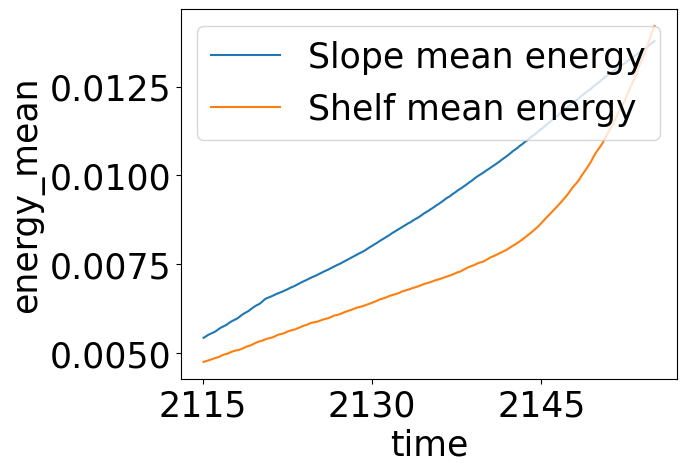

In [140]:
energy_mean_slopex.energy_mean.plot(label = 'Slope mean energy')
energy_mean_shelfx.energy_mean.plot(label = 'Shelf mean energy')
#(speed_mean_slopex.speed_mean**2).plot(label = 'Slope mean energy')
#(speed_mean_shelfx.speed_mean**2).plot(label = 'Shelf mean energy')
plt.legend() ##WRONG

In [47]:

energy_mean_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_slope_600m_sans_canyons.nc')
energy_mean_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_shelf_600m_sans_canyons.nc')
                              

## start loading to plot here for eddies
file generated using data MW_accessEKE_rolling.ipynb

In [48]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_' + expt + '_'+ str(xx_file)\
            + '_' + str(xx) + '.nc' for xx_file in range(4) for xx in range(3)]
FileList

['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_3_0.nc',
 '/g/data/v45/qo9901/MW-pertur

In [49]:
rho_0 = 1035
eke = np.sqrt(xr.open_mfdataset(FileList, combine = 'by_coords')/0.5/rho_0)
eke = xr.open_mfdataset(FileList, combine = 'by_coords')/0.5/rho_0

eke

<xarray.Dataset> Size: 6GB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600, time: 481)
Coordinates:
  * yu_ocean                       (yu_ocean) float64 4kB -78.98 ... -60.02
  * xu_ocean                       (xu_ocean) float64 29kB -279.9 ... 80.0
  * time                           (time) object 4kB 2115-01-16 12:00:00 ... ...
    geolon_c                       (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 300), meta=np.ndarray>
    geolat_c                       (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 300), meta=np.ndarray>
Data variables:
    __xarray_dataarray_variable__  (yu_ocean, xu_ocean, time) float64 6GB dask.array<chunksize=(440, 300, 481), meta=np.ndarray>

In [50]:
eddyspeed_t_shelf = grid.integrate(eke.where(cluster_mask_access == True)\
                                   .where(mask_shelf == True), axis = {'X','Y'}).load()/circ_area_shelf
eddyspeed_t_slope = grid.integrate(eke.where(cluster_mask_access == True)\
                                   .where(mask_slope == True), axis = {'X','Y'}).load()/circ_area_slope     

In [51]:
circ_area_shelf

array(2.9209776e+12)

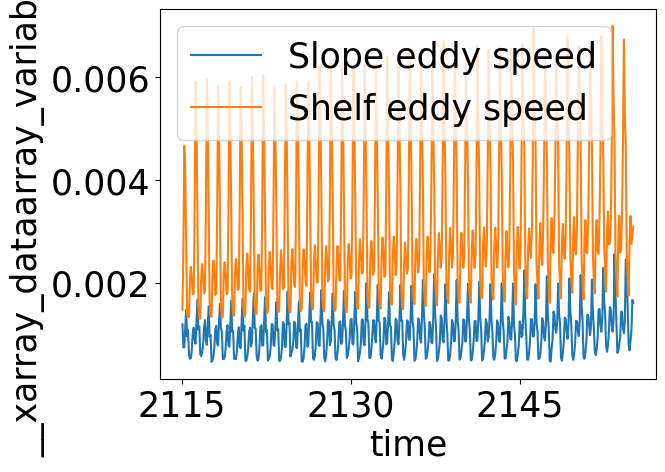

In [52]:
eddyspeed_t_slope.__xarray_dataarray_variable__.plot(label = 'Slope eddy speed')
eddyspeed_t_shelf.__xarray_dataarray_variable__.plot(label = 'Shelf eddy speed')
plt.legend()

## skip if only plotting - generating mean speed and cross terms to save

In [78]:
chunksize

30

In [79]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
energy_uup_vvp_slopematrix =[]
energy_uup_vvp_shelfmatrix = []
for tt in range(20):
    ushape = u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    vshape = v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    u_transient_clim = u.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - \
                        u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - \
                        v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    energy_uup_vvp_slope = (ushape*u_transientsel).where(cluster_mask_access == True).where(mask_slope == True) \
                    +  (vshape*v_transientsel).where(cluster_mask_access == True).where(mask_slope == True)
    energy_uup_vvp_slopematrix.append(grid.integrate(energy_uup_vvp_slope, axis = {'X','Y'}).load())
    
    energy_uup_vvp_shelf = (ushape*u_transientsel).where(cluster_mask_access == True).where(mask_shelf == True) \
                    +  (vshape*v_transientsel).where(cluster_mask_access == True).where(mask_shelf == True)
    energy_uup_vvp_shelfmatrix.append(grid.integrate(energy_uup_vvp_shelf, axis = {'X','Y'}).load())
    
    del energy_uup_vvp_slope, energy_uup_vvp_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
CPU times: user 1min 43s, sys: 1min 22s, total: 3min 5s
Wall time: 5min 26s


In [80]:
energy_uup_vvp_slopex = xr.merge([energy_uup_vvp_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_uup_vvp_slopematrix)))])/circ_area_slope        
energy_uup_vvp_shelfx = xr.merge([energy_uup_vvp_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_uup_vvp_shelfmatrix)))])/circ_area_shelf                                 

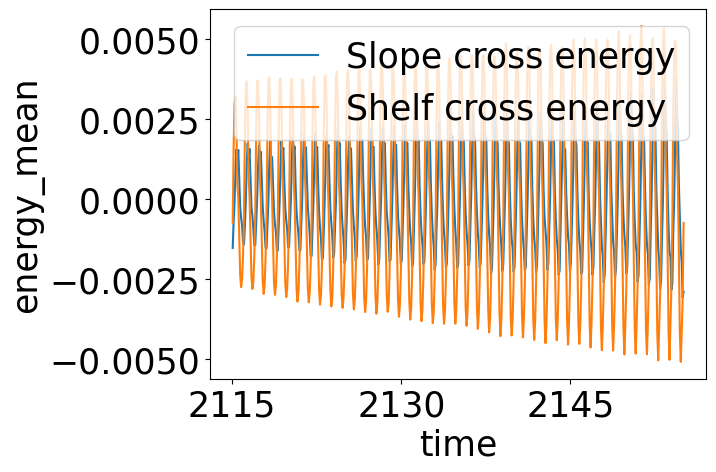

In [81]:
energy_uup_vvp_slopex.energy_mean.plot(label = 'Slope cross energy')
energy_uup_vvp_shelfx.energy_mean.plot(label = 'Shelf cross energy')
plt.legend()

In [83]:
energy_uup_vvp_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
                              + str(windows) + '_' + expt+ 'shelf_600m_sans_canyons.nc')
energy_uup_vvp_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
                             + str(windows) + '_' + expt+ 'slope_600m_sans_canyons.nc')

In [57]:
## for total speed
chunksize = 30

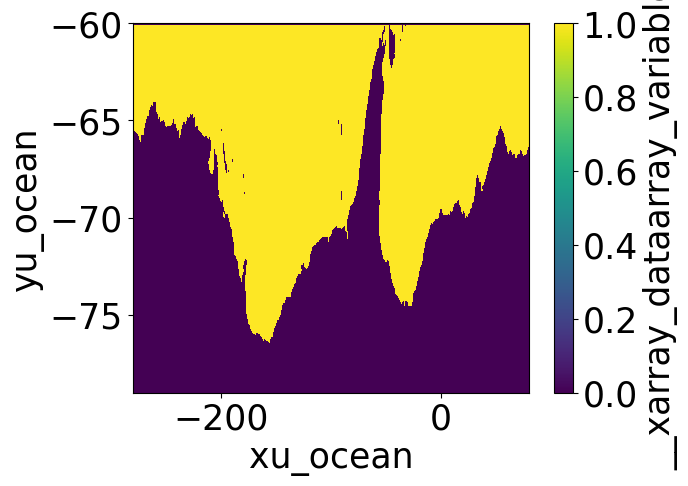

In [90]:
mask_slope.__xarray_dataarray_variable__.plot()

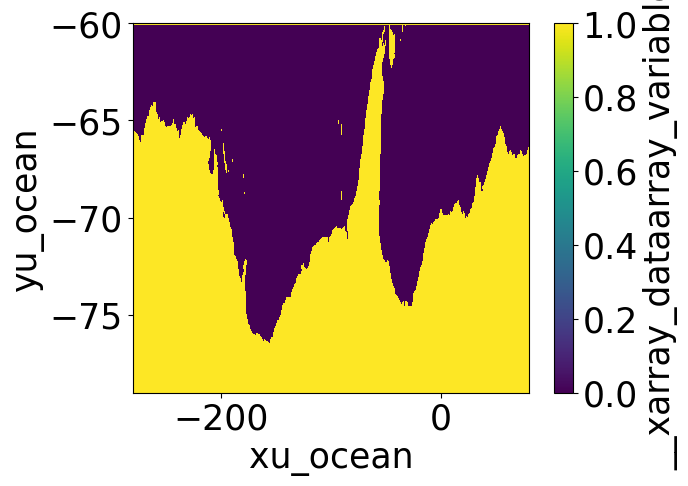

In [91]:
mask_shelf.__xarray_dataarray_variable__.plot()

In [60]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
speed_mean_slopematrix =[]
speed_mean_shelfmatrix = []
for tt in range(20):
    u_transient_clim = u.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = u.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    speed_mean_slope = np.sqrt(u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    speed_mean_slopematrix.append(grid.integrate(speed_mean_slope, axis = {'X','Y'}).load())
    
    speed_mean_shelf = np.sqrt(u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    speed_mean_shelfmatrix.append(grid.integrate(speed_mean_shelf, axis = {'X','Y'}).load())
    
    del speed_mean_slope, speed_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
CPU times: user 1min 45s, sys: 1min 36s, total: 3min 22s
Wall time: 5min 55s


In [61]:
speed_total_slopex = xr.merge([speed_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'speed'}) for i in np.arange(int(len(speed_mean_slopematrix)))])/circ_area_slope        
speed_total_shelfx = xr.merge([speed_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'speed'}) for i in np.arange(int(len(speed_mean_shelfmatrix)))])/circ_area_shelf                                 

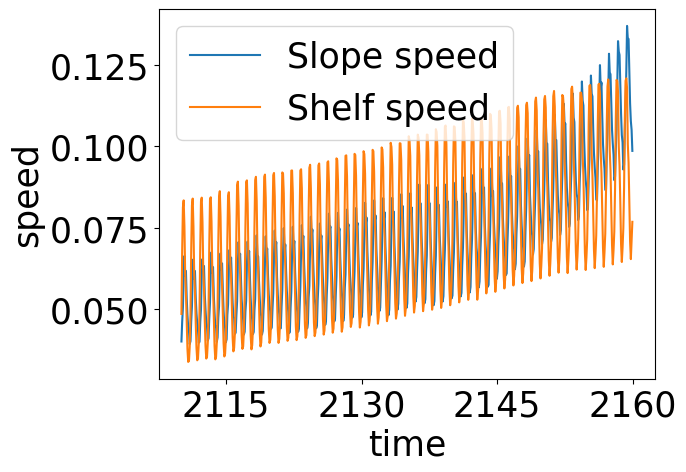

In [62]:
speed_total_slopex.speed.plot(label = 'Slope speed')
speed_total_shelfx.speed.plot(label = 'Shelf speed')
plt.legend()

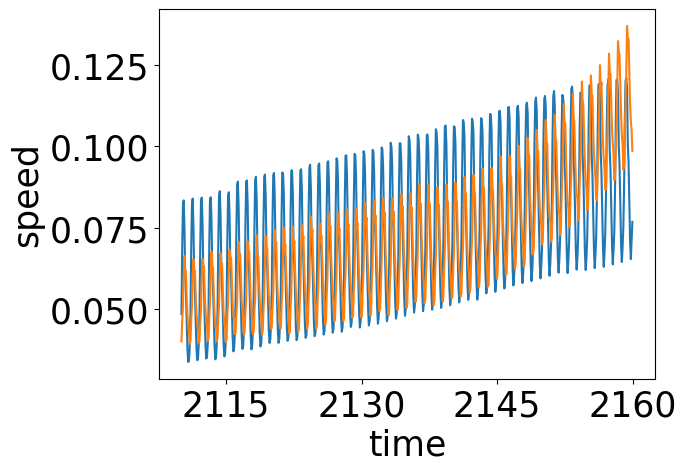

In [120]:
speed_total_slopex.speed.plot()#(label = 'Slope speed')
speed_total_shelfx.speed.plot() ##oLD

In [63]:

speed_total_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_surf_total_W' \
                              + str(windows) + '_' + expt+ 'shelf_600m_sans_canyons.nc')
speed_total_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_surf_total_W' \
                              + str(windows) + '_' + expt+ 'slope_600m_sans_canyons.nc')


In [64]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
energy_mean_slopematrix =[]
energy_mean_shelfmatrix = []
for tt in range(20):
    u_transient_clim = u.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = u.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    energy_mean_slope = (u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    energy_mean_slopematrix.append(grid.integrate(energy_mean_slope, axis = {'X','Y'}).load())
    
    energy_mean_shelf = (u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    energy_mean_shelfmatrix.append(grid.integrate(energy_mean_shelf, axis = {'X','Y'}).load())
    
    del energy_mean_slope, energy_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
CPU times: user 1min 44s, sys: 1min 37s, total: 3min 21s
Wall time: 5min 47s


In [65]:
energy_total_slopex = xr.merge([energy_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'energy'}) for i in np.arange(int(len(energy_mean_slopematrix)))])/circ_area_slope        
energy_total_shelfx = xr.merge([energy_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'energy'}) for i in np.arange(int(len(energy_mean_shelfmatrix)))])/circ_area_shelf                                 

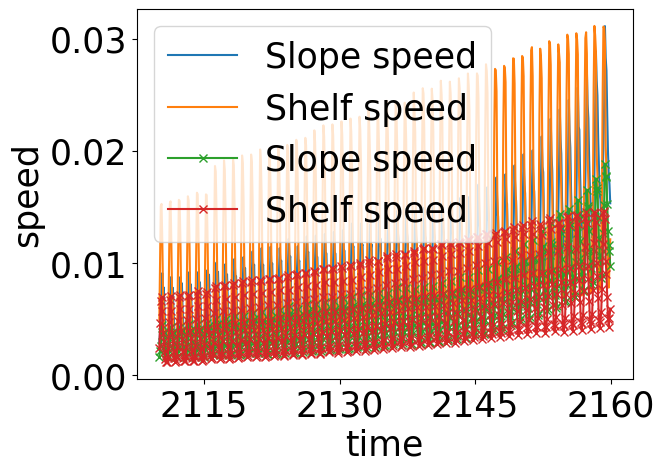

In [66]:
## energy and speed are not the same --- opt to use energy
energy_total_slopex.energy.plot(label = 'Slope speed')
energy_total_shelfx.energy.plot(label = 'Shelf speed')
(speed_total_slopex.speed**2).plot(label = 'Slope speed', marker = 'x')
(speed_total_shelfx.speed**2).plot(label = 'Shelf speed', marker = 'x')
plt.legend()

In [67]:
expt

'01deg_jra55v13_ryf9091_qian_wthmp'

In [68]:
energy_total_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_surf_total_W' \
                              + str(windows) + '_' + expt+ 'shelf_600m_sans_canyons.nc')
energy_total_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_surf_total_W' \
                              + str(windows) + '_' + expt+ 'slope_600m_sans_canyons.nc')

## importing to plot


In [84]:
#eddyspeed_t_shelf 
#eddyspeed_t_slope

energy_mean_slopex =  xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_slope_600m_sans_canyons.nc')
energy_mean_shelfx =  xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_shelf_600m_sans_canyons.nc')
energy_uup_vvp_shelfx= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
                              + str(windows) + '_' + expt+ 'shelf_600m_sans_canyons.nc')
energy_uup_vvp_slopex= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
                              + str(windows) + '_' + expt+ 'slope_600m_sans_canyons.nc')
energy_total_shelfx= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_surf_total_W' \
                              + str(windows) + '_' + expt+ 'shelf_600m_sans_canyons.nc')
energy_total_slopex= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_surf_total_W' \
                              + str(windows) + '_' + expt+ 'slope_600m_sans_canyons.nc')


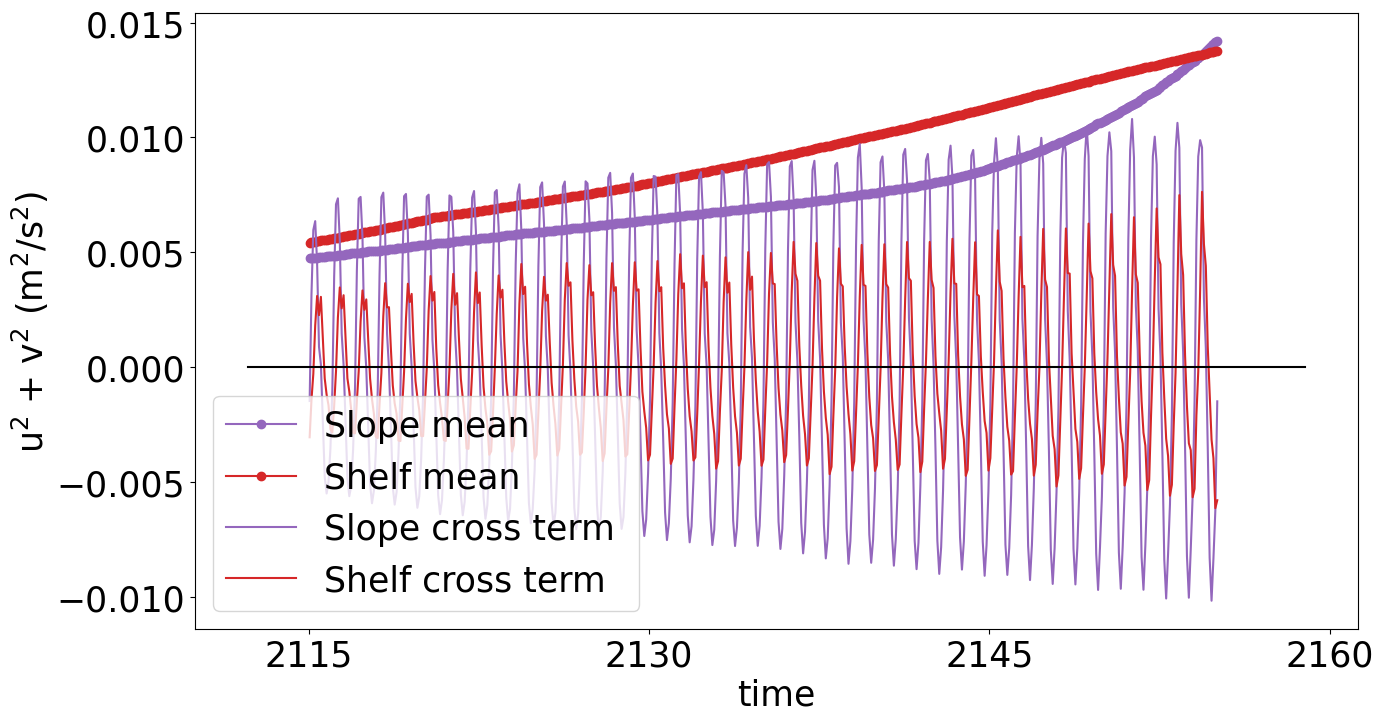

In [85]:
plt.figure(figsize = (15,8))
(energy_mean_slopex.energy_mean).plot(marker = 'o', color = 'C4', label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).plot(marker = 'o',color = 'C3',  label = 'Shelf mean ')
(2*energy_uup_vvp_slopex.energy_mean).plot( color = 'C4', label = 'Slope cross term ')
(2*energy_uup_vvp_shelfx.energy_mean).plot(color = 'C3', label = 'Shelf cross term ')
#(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
#(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)
plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')
plt.plot([41000,58000],[0,0], 'k')
plt.legend()

In [86]:
import matplotlib.lines as mlines


Text(0, 0.5, 'Kinetic Energy (m$^{2}$/s$^{2}$)')

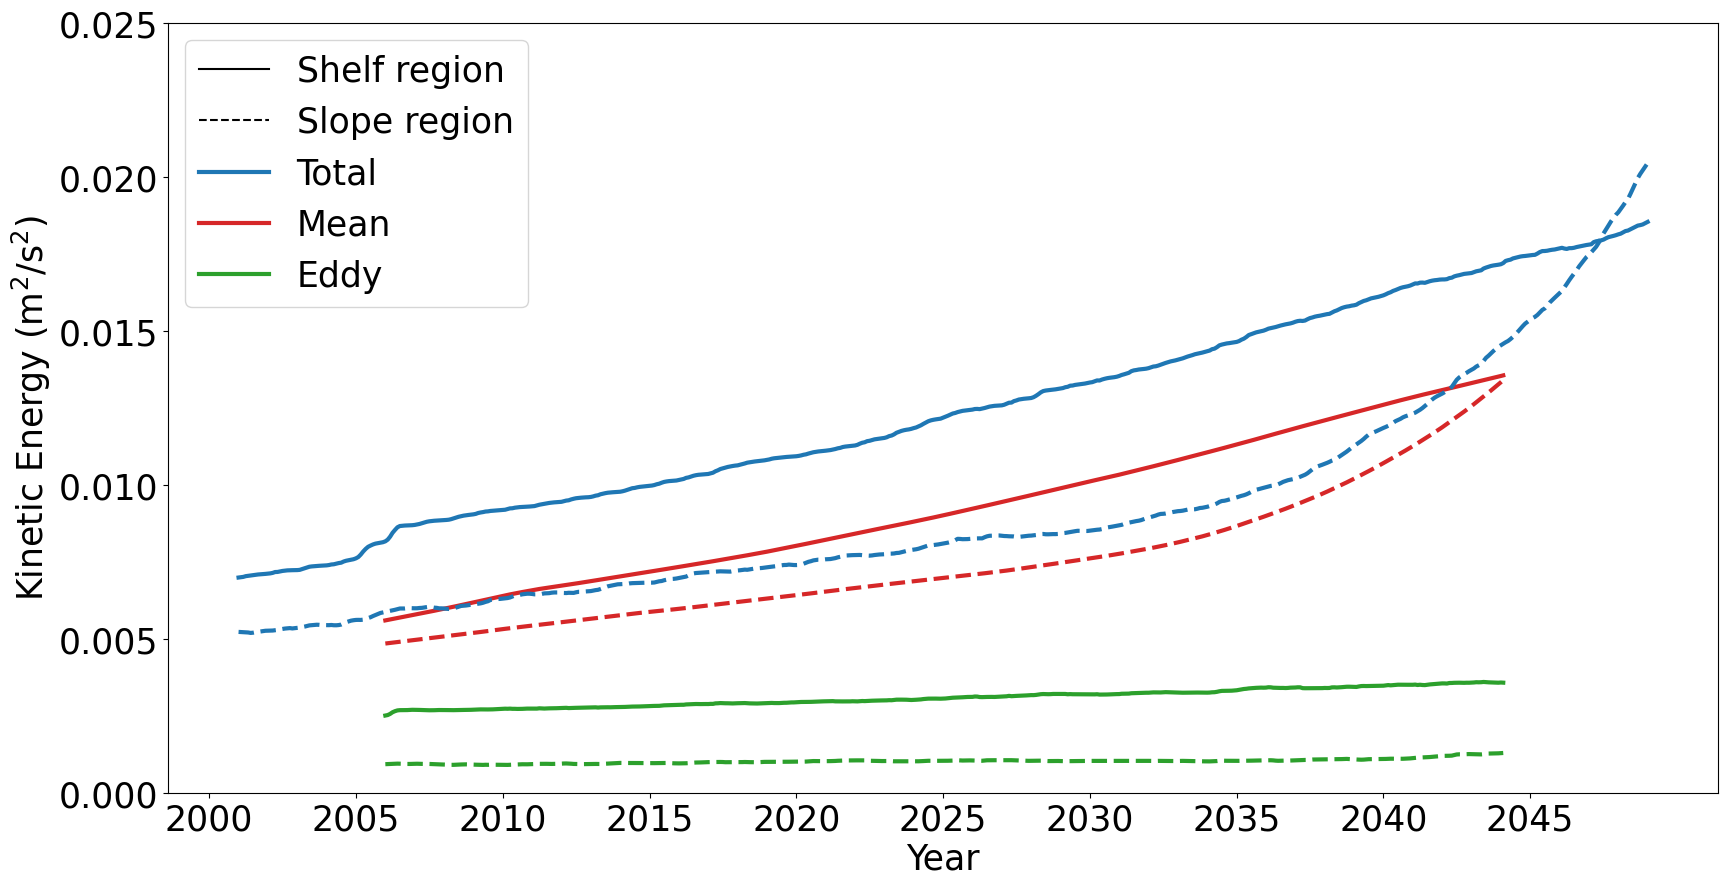

In [87]:
plt.figure(figsize = (20,10))
window_rolling = 12*2
(eddyspeed_t_slope.__xarray_dataarray_variable__).rolling(time = window_rolling, center = True).mean().plot(linestyle = 'dashed',color = 'C2', lw = 3,  label = 'Slope eddy ')
(eddyspeed_t_shelf.__xarray_dataarray_variable__).rolling(time = window_rolling, center = True).mean().plot( color = 'C2', lw = 3, label = 'Shelf eddy ')
(energy_mean_slopex.energy_mean).rolling(time = window_rolling, center = True).mean().plot(linestyle = 'dashed', color = 'C3', lw = 3, label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).rolling(time = window_rolling, center = True).mean().plot(color = 'C3', lw = 3,  label = 'Shelf mean ')

(energy_total_slopex.energy).rolling(time = window_rolling, center = True).mean().plot(color = 'C0', lw = 3,label = 'Slope energy', linestyle = 'dashed')
(energy_total_shelfx.energy).rolling(time = window_rolling, center = True).mean().plot(color = 'C0', lw = 3,label = 'Shelf energy')


# Custom legends
line1 = mlines.Line2D([], [], color='k', linestyle='solid', label='Shelf region')
line2 = mlines.Line2D([], [], color='k', linestyle='--', label='Slope region')
# ...
# Custom legend handles for colors (properties)
green_patch = mlines.Line2D([], [], color='C2', lw = 3, linestyle='-', label='Eddy')
red_patch = mlines.Line2D([], [], color='C3',lw = 3, linestyle='-', label='Mean')
blue_patch = mlines.Line2D([], [], color='C0',lw = 3, linestyle='-', label='Total')

# Creating the legend
plt.legend(handles=[line1, line2, blue_patch, red_patch, green_patch], loc='upper left')
plt.xticks(energy_total_slopex.time[::60].values, labels = range(2000,2050,5))
plt.xlabel('Year')
    
plt.ylim([0,0.025])
plt.ylabel('Kinetic Energy (m$^{2}$/s$^{2}$)')
#plt.plot([41000,58000],[0,0], 'k')
#plt.legend(fontsize = 16)

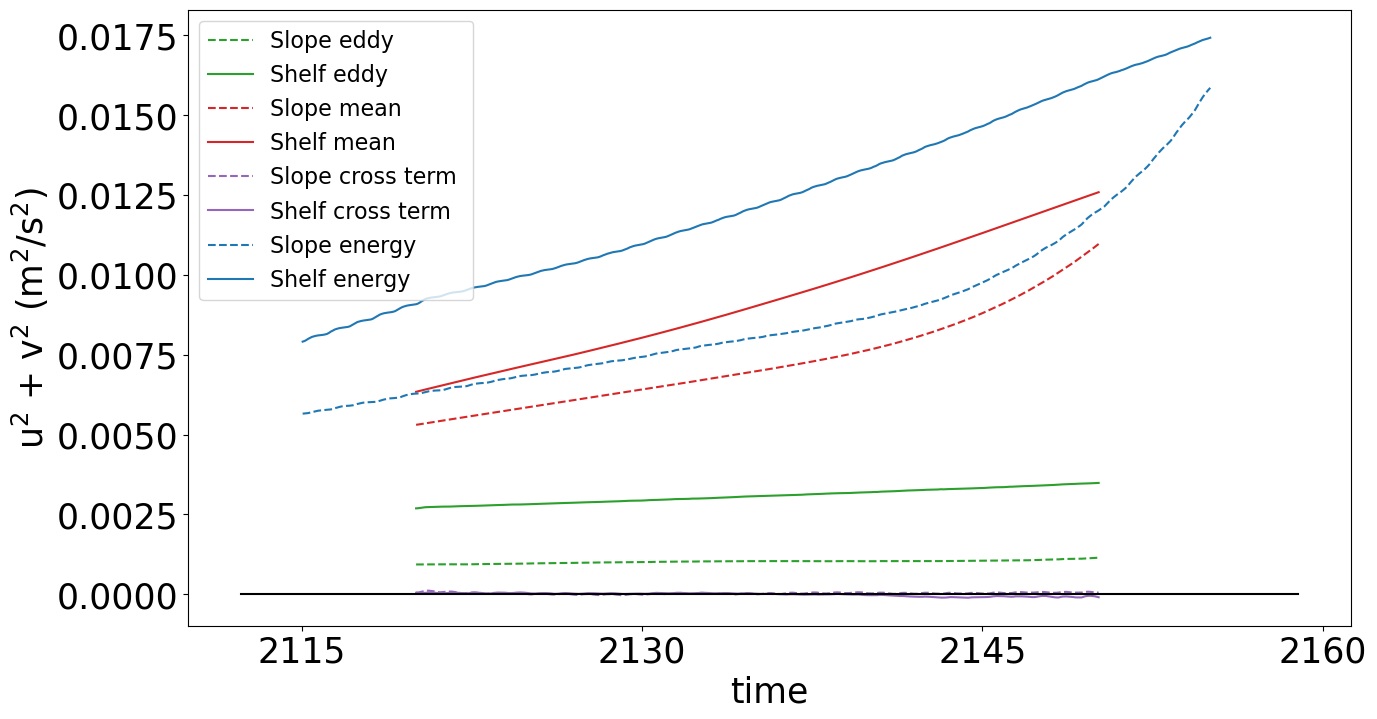

In [88]:
plt.figure(figsize = (15,8))
window_rolling = 120
(eddyspeed_t_slope.__xarray_dataarray_variable__).rolling(time = window_rolling, center = True).mean().plot(linestyle = 'dashed',color = 'C2',  label = 'Slope eddy ')
(eddyspeed_t_shelf.__xarray_dataarray_variable__).rolling(time = window_rolling, center = True).mean().plot( color = 'C2', label = 'Shelf eddy ')
(energy_mean_slopex.energy_mean).rolling(time = window_rolling, center = True).mean().plot(linestyle = 'dashed', color = 'C3', label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).rolling(time = window_rolling, center = True).mean().plot(color = 'C3',  label = 'Shelf mean ')
(2*energy_uup_vvp_slopex.energy_mean).rolling(time = window_rolling, center = True).mean().plot(linestyle = 'dashed', color = 'C4', label = 'Slope cross term ')
(2*energy_uup_vvp_shelfx.energy_mean).rolling(time = window_rolling, center = True).mean().plot(color = 'C4', label = 'Shelf cross term ')
#(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
#(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)

(energy_total_slopex.energy).rolling(time = window_rolling, center = True).mean().plot(color = 'C0',label = 'Slope energy', linestyle = 'dashed')
(energy_total_shelfx.energy).rolling(time = window_rolling, center = True).mean().plot(color = 'C0',label = 'Shelf energy')

plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')
plt.plot([41000,58000],[0,0], 'k')
plt.legend(fontsize = 16)

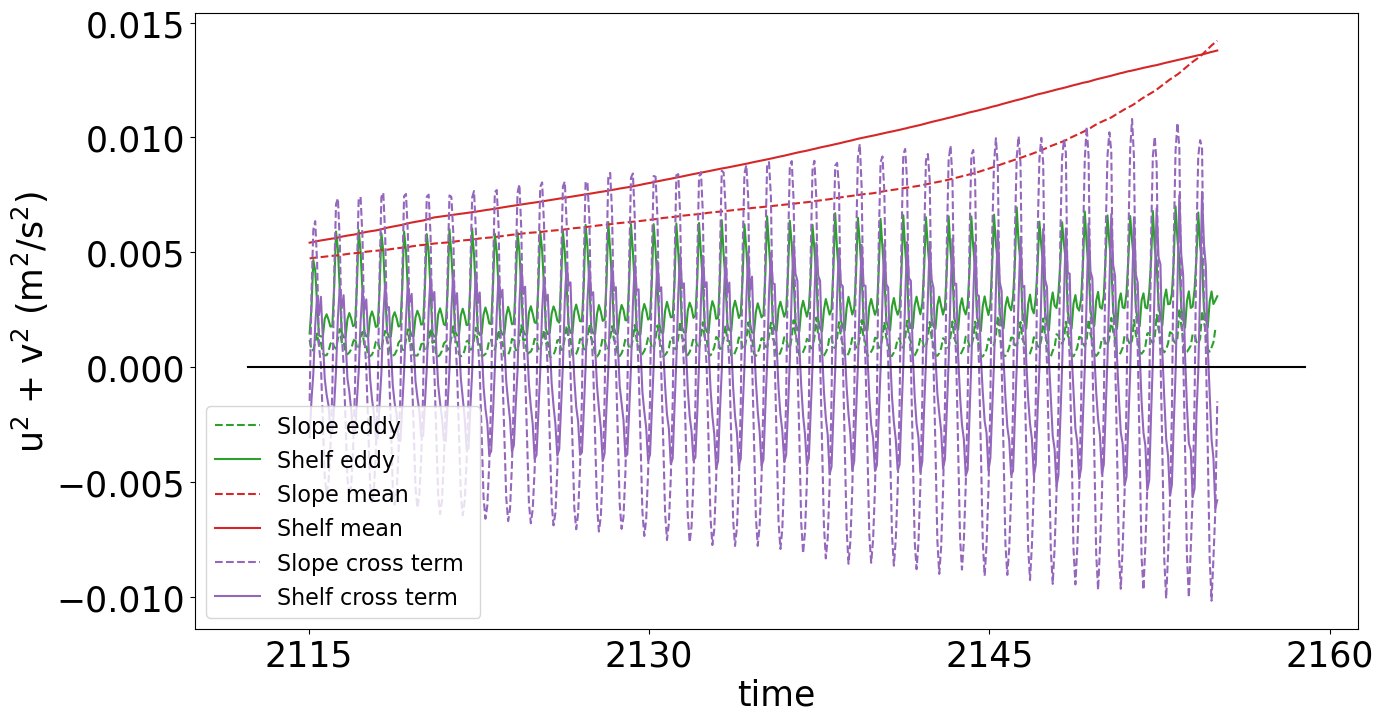

In [89]:
plt.figure(figsize = (15,8))
(eddyspeed_t_slope.__xarray_dataarray_variable__).plot(linestyle = 'dashed',color = 'C2',  label = 'Slope eddy ')
(eddyspeed_t_shelf.__xarray_dataarray_variable__).plot( color = 'C2', label = 'Shelf eddy ')
(energy_mean_slopex.energy_mean).plot(linestyle = 'dashed', color = 'C3', label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).plot(color = 'C3',  label = 'Shelf mean ')
(2*energy_uup_vvp_slopex.energy_mean).plot(linestyle = 'dashed', color = 'C4', label = 'Slope cross term ')
(2*energy_uup_vvp_shelfx.energy_mean).plot(color = 'C4', label = 'Shelf cross term ')
#(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
#(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)

#(energy_total_slopex.energy).plot(color = 'C0',label = 'Slope energy', linestyle = 'dashed')
#(energy_total_shelfx.energy).plot(color = 'C0',label = 'Shelf energy')

plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')
plt.plot([41000,58000],[0,0], 'k')
plt.legend(fontsize = 16)